# [AR] Contexts and their generation

Consider the case in which there are three classes of users (C1, C2, and C3), and no information about the advertising and pricing curves is known beforehand. Consider two scenarios. 

In the first one, the structure of the contexts is known beforehand. Apply the GP-UCB and GP-TS algorithms when using GPs to model the two advertising curves, reporting the plots with the average (over a sufficiently large number of runs) value and standard deviation of the cumulative regret, cumulative reward, instantaneous regret, and instantaneous reward. 

In the second scenario, the structure of the contexts is not known beforehand and needs to be learnt from data. 

Important remark: the learner does not know how many contexts there are, while it can only observe the features and data associated with the features. 

Apply the GP-UCB and GP-TS algorithms when using GPs to model the two advertising curves paired with a context generation algorithm, reporting the plots with the average (over a sufficiently large number of runs) value and standard deviation of the cumulative regret, cumulative reward, instantaneous regret, and instantaneous reward. 

Apply the context generation algorithms every two weeks of the simulation. 
Compare the performance of the two algorithms --- the one used in the first scenario with the one used in the second scenario. 

Furthermore, in the second scenario, run the GP-UCB and GP-TS algorithms without context generation, and therefore forcing the context to be only one for the entire time horizon, and compare their performance with the performance of the previous algorithms used for the second scenario.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from User_Classes import UserClass
from UCB import *
from tqdm import tqdm
from Learner import *
import numpy as np
import matplotlib.pyplot as plt
from Pricing_Environment import *
from Advertising_Environment import *
from TS_Learner import *

In [2]:
uc1 = UserClass(name = "C1")
uc2 = UserClass(name = "C2")
uc3 = UserClass(name = "C3")

user_classes = [uc1, uc2, uc3]

## Environment

In [3]:
class Environment_Pricing_4():
    def __init__(self, n_arms):
        self.classes = [
            UserClass(name = 'C1'),
            UserClass(name = 'C2'),
            UserClass(name = 'C3')
        ]
        self.prices = [50, 100, 150, 200, 250]
        self.time = 0
        self.n_arms = n_arms
        self.p1 = self.classes[0].get_conversion_probabilities()
        self.p2 = self.classes[1].get_conversion_probabilities()
        self.p3 = self.classes[2].get_conversion_probabilities()
        self.ad_env = Advertising_Environment()

    def get_conversion_price_probability(self, class_index, price_index):
        prob = self.classes[class_index].get_conversion_probabilities()[price_index]
        return prob

    def round(self, class_index, price_index, bid=1):
        prices = [50,100,150,200,250]
        clicks = self.ad_env.generate_observations(noise_std_clicks=0, bid=bid, index=class_index)
        conversion_prob = np.random.binomial(1, self.get_conversion_price_probability(0, price_index))
        margin = prices[price_index] - (prices[price_index]/100)*30
        costs = self.ad_env.get_total_cost(noise_std_cost=0, bid=bid, index=class_index)
        reward = clicks * conversion_prob * margin - costs
        self.time += 1
        return reward

In [13]:
def fun(user_class, bid, price):
    mean_per_bid = user_class.get_click_bids(bid) * (user_class.get_conversion_per_price(price) * calculate_margin(price)) - user_class.get_click_bids(bid) * user_class.get_cost_per_click(bid)    #sample_cost
    return mean_per_bid

class BiddingEnvironment:
    def __init__(self, bids, sigma, user_classes, price, n_arms):
        self.bids = bids
        self.means = [
            self.initialize_means(user_class=user_classes[0], bids=bids, price=price),
            self.initialize_means(user_class=user_classes[1], bids=bids, price=price),
            self.initialize_means(user_class=user_classes[2], bids=bids, price=price)
        ]
        self.sigmas = np.ones(len(bids)) * sigma
        self.price = price
        self.n_arms = n_arms

    def initialize_means(self, user_class, bids, price):
        means = np.zeros(len(bids))
        for i in range(len(means)):
            means[i] = fun(user_class, bids[i], price)
        return means

    def round(self, pulled_arm, user_class):
        return np.random.normal(self.means[user_class][pulled_arm], self.sigmas[pulled_arm])

## GP-TS

In [5]:
%cd ..

c:\Users\Andrea\Documents\GitHub\OLA_2023_Private


In [16]:
from bandit_algorithms.Learner import *
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

class GPTS_Learner(Learner):
    def __init__(self, n_arms, arms):
        super().__init__(n_arms)
        self.arms = arms
        self.means = np.zeros(self.n_arms)
        self.sigmas = np.ones(self.n_arms)*10
        self.pulled_arms = []
        alpha = 10.0
        #kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
        #kernel_BlueCow
        kernel = C(100, (100, 1e6)) * RBF(1, (1e-1, 1e1))
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha**2, normalize_y=True, n_restarts_optimizer= 9)

    #override to update the value of the pulled arms list
    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)
        self.pulled_arms.append(self.arms[arm_idx])
    #update the means and sigmas with the new predictions
    def update_model(self):
        x = np.atleast_2d(self.pulled_arms).T
        y = self.collected_rewards
        self.gp.fit(x,y)
        self.means, self.sigmas = self.gp.predict(np.atleast_2d(self.arms).T, return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-2)
    #calls both update lists
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.update_model()
    #returns the index of the max value drawn from the arm normal distribution
    def pull_arm(self):
        sampled_values = np.random.normal(self.means, self.sigmas)
        return np.argmax(sampled_values)

## GP-UCB

In [7]:
from bandit_algorithms.Learner import *
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

class GPUCB_Learner(Learner):
    def __init__(self, n_arms, arms):
        super().__init__(n_arms)
        self.arms = arms
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.array([np.inf] * n_arms)
        self.pulled_arms = []
        alpha = 10.0
        # kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
        # kernel_BlueCow
        kernel = C(100, (100, 1e6)) * RBF(1, (1e-1, 1e1))
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha ** 2, normalize_y=True, n_restarts_optimizer=9)

    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)
        self.pulled_arms.append(self.arms[arm_idx])
    def update_model(self):
        x = np.atleast_2d(self.pulled_arms).T
        y = self.collected_rewards
        self.gp.fit(x,y)
        self.means, self.sigmas = self.gp.predict(np.atleast_2d(self.arms).T, return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-2)
    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_conf == upper_conf.max())[0])

    def update(self, pull_arm, reward):
        self.t += 1
        self.empirical_means[pull_arm] = (self.empirical_means[pull_arm] * (self.t - 1) + reward) / self.t
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] = (2 * np.log(self.t) / n_samples) ** 0.5 if n_samples > 0 else np.inf
        self.update_observations(pull_arm, reward)
        self.update_model()

## Experiments

### First scenario

In [19]:
n_arms = 10
#Creating the pricing environment
env_pr = Environment_Pricing_4(n_arms=n_arms)

#Defining adv variables and creating the adv env
n_arms = 100
min_bid = 0.01
max_bid = 3.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 200

prices = env_pr.prices
optimal_prices = [200, 200, 150]
 
T = 365

n_experiments = 1
gpts_rewards_per_experiment = []

In [17]:
#for each experiment, for each day, for each class -> different prices are considered. Let's start by considering class 0's optimal price
for e in range(n_experiments):
    GPTS_learners = [GPTS_Learner(n_arms, bids), GPTS_Learner(n_arms, bids), GPTS_Learner(n_arms, bids)]
    env_adv = BiddingEnvironment(bids=bids, n_arms=n_arms, price=optimal_prices[0], sigma=200, user_classes=user_classes)
    for t in range(T):
        for user_class in range(len(user_classes)):
            #GP Thompson Sampling
            pulled_arm = GPTS_learners[user_class].pull_arm() #pull one arm out of those 100
            reward = env_adv.round(pulled_arm, user_class)
            GPTS_learners[user_class].update(pulled_arm, reward)

    gpts_rewards_per_experiment.append(GPTS_learners[user_class].collected_rewards)

c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernel

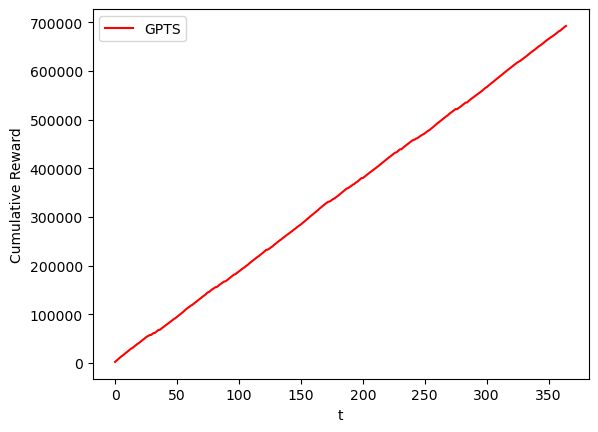

In [18]:
plt.figure(0)
plt.ylabel("Cumulative Reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
plt.legend()
plt.show()

### Second scenario